# Reading MOD09 granules

In [1]:
import staremaster

In [2]:
from pyhdf.SD import SD
import numpy
import pystare
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import geopandas

In [3]:
import importlib
import sys
sys.path.insert(0,'../') 

In [4]:
import staremaster.products
importlib.reload(staremaster.products)

<module 'staremaster.products' from '/home/griessbaum/Dropbox/UCSB/STARE_Project/STAREMaster_py/staremaster/products/__init__.py'>

## Bad MOD09

In [5]:
file_path = '../tests/data/MOD09.A2002299.0710.006.2015151173939.hdf'
granule = staremaster.products.MOD09(file_path)

In [6]:
granule.load()

In [7]:
granule.lats

{'1km': masked_array(
   data=[[--, --, --, ..., 36.22785186767578, 36.22285079956055,
          36.21782302856445],
         [--, --, --, ..., 36.24024200439453, 36.235260009765625,
          36.23025131225586],
         [--, --, --, ..., 36.25263214111328, 36.24766540527344,
          36.242679595947266],
         ...,
         [--, --, --, ..., 53.46763610839844, 53.460235595703125,
          53.45280075073242],
         [--, --, --, ..., 53.479496002197266, 53.472110748291016,
          53.464691162109375],
         [--, --, --, ..., 53.49135208129883, 53.483985900878906,
          53.47658157348633]],
   mask=[[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],
   fill_value=1e+20),
 

In [31]:
import netCDF4 
i = sids.shape[0]
j = sids.shape[1]
varname = 's1'
i_name = 'i'
j_name = 'j'
if nom_res:    
    i_name += '_{nom_res}'.format(nom_res=nom_res)
    j_name += '_{nom_res}'.format(nom_res=nom_res)   
with netCDF4.Dataset('/home/griessbaum/Dropbox/UCSB/STARE_Project/STAREMaster_py/tests/data/MOD09.A2002299.0710.006.2015151173939_stare.nc', 'a', format="NETCDF4") as rootgrp:
    grp = rootgrp    
    sids_netcdf = grp.createVariable(varname=varname, 
                                     datatype='u8', 
                                     dimensions=(i_name, j_name),
                                     chunksizes=[i, j],
                                     shuffle=True,
                                     zlib=True,
                                     fill_value=-1)
    sids_netcdf.long_name = 'SpatioTemporal Adaptive Resolution Encoding (STARE) index'
    sids_netcdf[:, :] = sids

In [ ]:
granule.create_sidecar(n_workers=4)

In [14]:
a = None
if a is None: 
    print(10)

10


In [20]:
sids = granule.sids['1km']
#sids = sids[sids.mask == False]
#staremaster.conversions.min_resolution(sids)

## Mod09

In [7]:
file_path = '/home/griessbaum/MOD09.A2012244.1835.006.2015248083747.hdf'
granule = staremaster.products.MOD09(file_path)

In [8]:
granule.read_gring()
granule.read_laton()

In [14]:
sids = staremaster.conversions.latlon2stare(granule.lats['1km'], 
                                            granule.lons['1km'], 
                                            n_workers=4)

In [15]:
cover_res = int(pystare.spatial_resolution(sids).max())
cover_sids = pystare.to_nonconvex_hull_range_from_latlon(granule.gring_lats,
                                                         granule.gring_lats,
                                                         cover_res)

In [121]:
# iterating over scan groups

lat_500 = []
lon_500 = []

for group_start in range(0, 2030, 10):
    group_lats = granule.lats['1km'][group_start:group_start+10]
    group_lons = granule.lons['1km'][group_start:group_start+10]    
    
    # Zoom out by factor (2n-1)/2; I.e. 2707/1354 in scan, 19/10 in track 
    lat_500_g = scipy.ndimage.zoom(group_lats, (19/10, 2707/1354), order=1)
    lon_500_g = scipy.ndimage.zoom(group_lons, (19/10,  2707/1354), order=1)
    
    # Calculate the gradient to 
    # a) shift 0.5 lenghts (250 m) in track direction and 1 length (500 m) in scan direction
    # b) Extrapolate the last observation in track direction
    # c) Extrapolate the last observation in scan direction
    
    # First/x axis is track
    # Second/y axis is scan
    
    gxx_lat, gyy_lat = numpy.gradient(lat_500_g)
    lat_500_g = lat_500_g - 0.5*gxx_lat# - 1*gyy_lat    
    lat_final_x = lat_500_g[-1] + 1*gxx_lat[-1]         # Last track of group
    lat_500_g = numpy.append(lat_500_g, [lat_final_x], axis=0)
    
    gxx_lon, gyy_lon = numpy.gradient(lon_500_g)
    lon_500_g = lon_500_g - 0.5*gxx_lon# - 1*gyy_lon
    lon_final_x = lon_500_g[-1] + 1*gxx_lon[-1]          # Last track of group
    lon_500_g  = numpy.append(lon_500_g, [lon_final_x], axis=0) 
    
    lat_final_y = lat_500_g[:, -1] + numpy.gradient(lat_500_g)[1][:, -1] # Last scan
    lat_500_g = numpy.append(lat_500_g.T, [lat_final_y], axis=0).T
    
    lon_final_y = lon_500_g[:, -1] + numpy.gradient(lon_500_g)[1][:, -1] # Last scan
    lon_500_g = numpy.append(lon_500_g.T, [lon_final_y], axis=0).T
            
    lat_500.append(lat_500_g)
    lon_500.append(lon_500_g)
    
lat_500 = numpy.concatenate(lat_500)
lon_500 = numpy.concatenate(lon_500)

In [122]:
#sids = staremaster.conversions.latlon2stare(lat_500, lon_500, n_workers=4)

# Verification Plots

<AxesSubplot:>

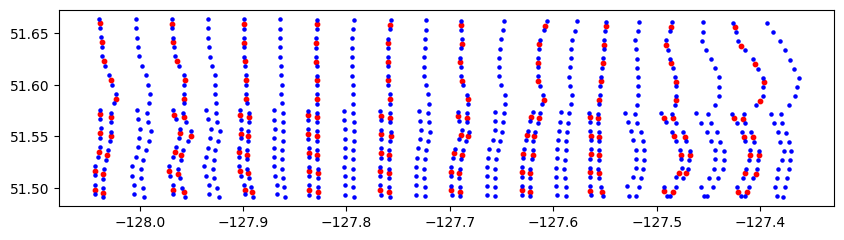

In [123]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons['1km'][0:15, 0:10].flatten(), 
                                                              granule.lats['1km'][0:15, 0:10].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, 0:20].flatten(), 
                                                               lat_500[0:30, 0:20].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')

<AxesSubplot:>

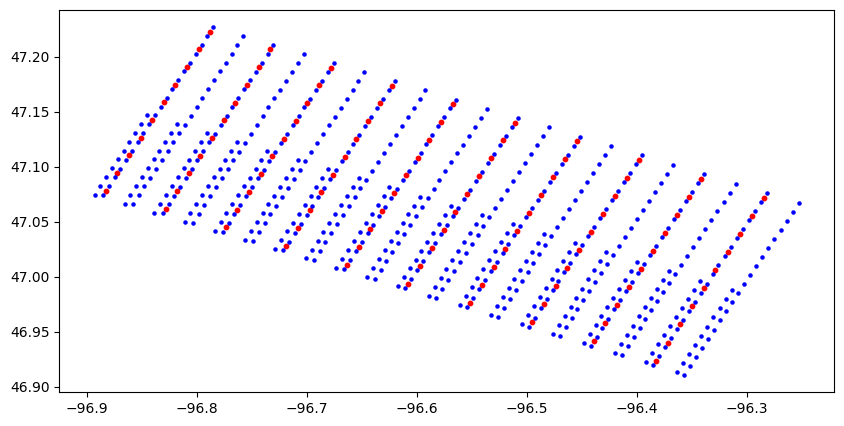

In [125]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons['1km'][0:10, -10:].flatten(), 
                                                              granule.lats['1km'][0:10, -10:].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, -20:].flatten(), 
                                                               lat_500[0:30, -20:].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')

<AxesSubplot:>

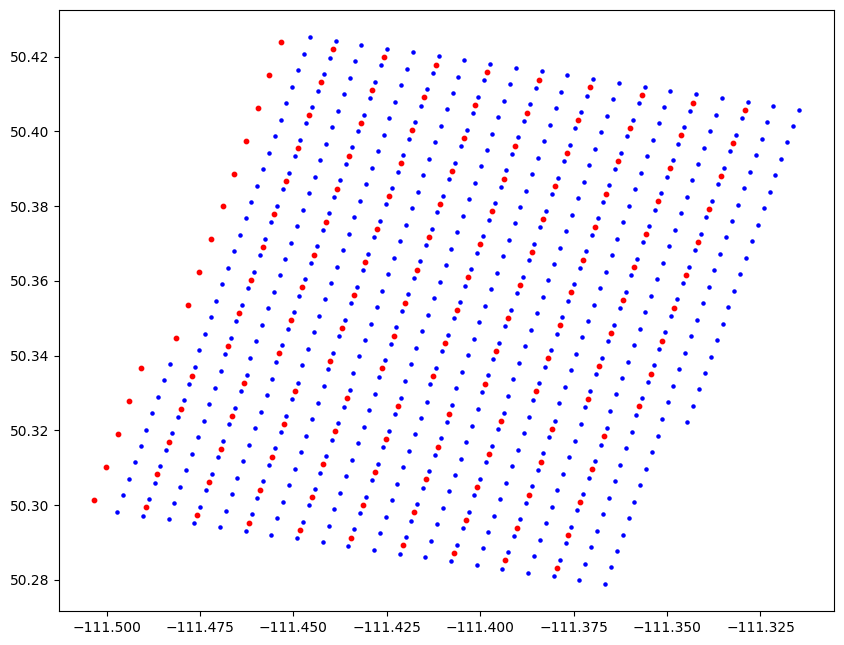

In [59]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons['1km'][0:15, 670:680].flatten(), 
                                                              granule.lats['1km'][0:15, 670:680].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, 1340:1360].flatten(), 
                                                               lat_500[0:30, 1340:1360].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')

<AxesSubplot:>

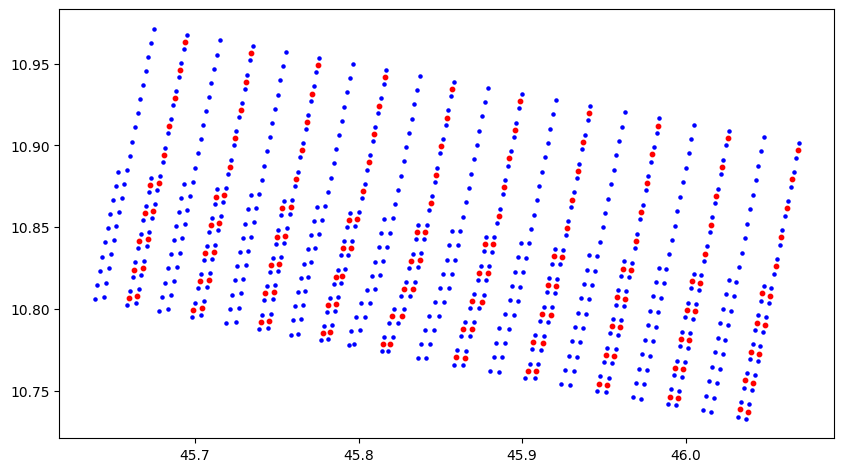

In [909]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons[0:15, -10:].flatten(), 
                                                              granule.lats[0:15, -10:].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, -20:].flatten(), 
                                                               lat_500[0:30, -20:].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')